## Malaria identification using Convolutional Neural Networks (CNN)

### Necessary imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.preprocessing import image


import warnings
warnings.filterwarnings('ignore')

### Data Visualization and Pre-processing

In [2]:
# path of the directory where the images are stored (would change depending on where one stores the images)
data_dir='E:\DS_ML\cell_images'

In [3]:
# lists all the folders in that directory
os.listdir(data_dir)

['test', 'train']

In [5]:
# path for the train data
train_path=data_dir+'\\train'

# path for the test data
test_path=data_dir+'\\test'

In [6]:
os.listdir(train_path)

['parasitized', 'uninfected']

In [7]:
os.listdir(test_path)

['parasitized', 'uninfected']

**train and test folders are divided into two categories, "parasitized" and "uninfected"**


In [24]:
print("The number of uninfected images in the train set: ",len(os.listdir(train_path+'\\uninfected')))
print("The number of infected images in the train set: ",len(os.listdir(train_path+'\\parasitized')))
print("The number of uninfected images in the test set: ",len(os.listdir(test_path+'\\uninfected')))
print("The number of infected images in the test set: ",len(os.listdir(test_path+'\\parasitized')))

The number of uninfected images in the train set:  12479
The number of infected images in the train set:  12479
The number of uninfected images in the test set:  1300
The number of infected images in the test set:  1300


**The dataset is balanced with equal number of infected and uninfected cells in the train and test directories.**

In [10]:
# fetching the first image from the parasitized category
img_infected=os.listdir(train_path+'\\parasitized')[0]
img_infected

'C100P61ThinF_IMG_20150918_144104_cell_162.png'

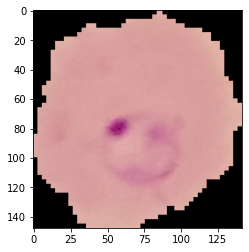

In [18]:
# visualizing the infected image
para_cell=train_path+'\\parasitized\\'+img_infected
para_img=imread(para_cell)
plt.imshow(para_img)

In [19]:
# shape of the image
para_img.shape

(148, 142, 3)

**The shape of the image is of the form (height, width, number of color channels). The number of color channels for grey scale (black/white) images is 1 whereas that for colored (RGB) images is 3.**

In [12]:
# fetching the first image from the uninfected category
img_uninfected=os.listdir(train_path+'\\uninfected')[0]
img_uninfected

'C100P61ThinF_IMG_20150918_144104_cell_128.png'

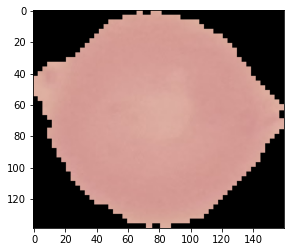

In [21]:
# visualizing the uninfected image
un_cell=train_path+'\\uninfected\\'+img_uninfected
uninfected_img=imread(un_cell)
plt.imshow(uninfected_img)

In [22]:
# shape of the image
uninfected_img.shape

(139, 160, 3)

**We can clearly see a difference between the image of an infected cell and that of an uninfected cell. Now we need to train a model which would see an image and based on the difference classify it as infected or uninfected.**

In [15]:
# We would find the average dimension of the images so that we can scale all the images to the average dimensions

# lists for storing the dimensions
dim1=[]
dim2=[]

for img_file in os.listdir(train_path+'\\uninfected'):
    img=imread(train_path+'\\uninfected\\'+img_file)   # reading images one by one
    d1,d2,col=img.shape
    dim1.append(d1)
    dim2.append(d2)

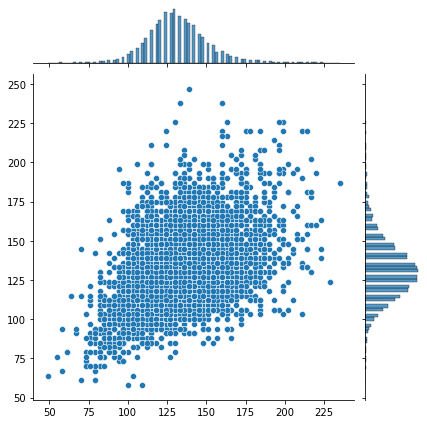

In [16]:
# plotting the dimensions
sns.jointplot(dim1,dim2)

In [17]:
np.mean(dim1), np.mean(dim2)

(131.64820899110507, 131.4041990544114)

**The average size of the images is about 130 x 130 pixels. So we would reshape all images to the mean dimensions for the deep learning model.**

In [37]:
# The dimension of an image is of the form (width, height, number of color channels)
img_shape=(130,130,3)

### Image Manipulation

There are about 25000 images in the training set and 2600 images in the test set, which is too much data to load into the model at a particular time. To handle large image data we can use the built in libraries provided by keras which can manipulate the data, process the data and generate a batch flow from the directory. 

**ImageDataGenerator** provided by keras does exactly the same task specified above. It takes in a whole range of parameters such as width_shift_range (changing the width of the image), height_shift_range (changing the height of the image), rescaling etc. This way we can manipulate the images and pass it to our model making it more robust to all the different kinds of possible images which our not in our dataset.

In order to use .flow_from_directory, you must organize the images in sub-directories. This is an absolute requirement, otherwise the method won't work. The directories should only contain images of one class, so one folder per class of images.

Structure Needed:

* Image Data Folder
    * Class 1
        * 0.jpg
        * 1.jpg
        * ...
    * Class 2
        * 0.jpg
        * 1.jpg
        * ...
    * ...
    * Class n

In [27]:
# uncomment the following command to get a full documentation for ImageDataGenerator

# help(ImageDataGenerator)

In [32]:
img_gen = ImageDataGenerator(rotation_range=20,      # rotate the image by a max of 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 5%
                               height_shift_range=0.10, # Shift the pic height by a max of 5%
                               rescale=1/255,        # Rescale the image by normalzing it.
                               shear_range=0.1,       # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1,        # Zoom in by 10% max
                               horizontal_flip=True,   # Allow horizontal flipping
                               fill_mode='nearest',     # Fill in missing pixels with the nearest filled value
                               vertical_flip=True
                              )

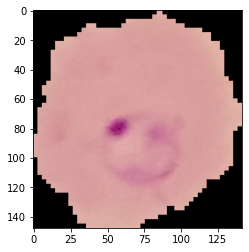

In [30]:
# original image
plt.imshow(para_img)

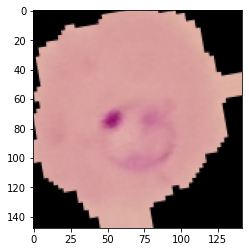

In [33]:
# image after transforming using the ImageDataGenerator
plt.imshow(img_gen.random_transform(para_img))

In [34]:
# creating a flow from the training directory
img_gen.flow_from_directory(train_path)

Found 24958 images belonging to 2 classes.


In [35]:
# creating a flow from the test directory
img_gen.flow_from_directory(test_path)

Found 2600 images belonging to 2 classes.


### Model Creation

We would be creating a sequential model and adding the convolution and pooling layers

In [38]:
model=Sequential()

model.add(Conv2D(filters=32,kernel_size=(3,3),input_shape=img_shape,activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64,kernel_size=(3,3),input_shape=img_shape,activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=128,kernel_size=(3,3),input_shape=img_shape,activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))

# final output layer 
model.add(Dense(1,activation='sigmoid'))

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [39]:
# stopping the training if the val_loss increases which means we are overfitting the data
early_stop=EarlyStopping(monitor='val_loss',mode='min',patience=2)

In [41]:
# the size of the batch in which images flow from the directory
batch_size=32

In [42]:
train_img_gen=img_gen.flow_from_directory(directory=train_path,
                                          target_size=img_shape[:2],   # only requires the height and width
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='binary')

Found 24958 images belonging to 2 classes.


In [43]:
test_img_gen=img_gen.flow_from_directory(directory=test_path,
                                         target_size=img_shape[:2],
                                         color_mode='rgb',
                                         batch_size=batch_size,
                                         class_mode='binary',
                                         shuffle=False)   

# we are not shuffling the test set because it would shuffle the labels (uninfected/infected) as well

Found 2600 images belonging to 2 classes.


In [44]:
# classes we are predicting
train_img_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

**Training the model**

In [45]:
# fitting the model on the training data
results=model.fit(train_img_gen,epochs=20,callbacks=[early_stop],validation_data=test_img_gen)

Epoch 1/20
780/780 [==============================] - 585s 684ms/step - loss: 0.3690 - accuracy: 0.8453 - val_loss: 0.1995 - val_accuracy: 0.9273
Epoch 2/20
780/780 [==============================] - 186s 238ms/step - loss: 0.1817 - accuracy: 0.9426 - val_loss: 0.1775 - val_accuracy: 0.9388
Epoch 3/20
780/780 [==============================] - 185s 237ms/step - loss: 0.1671 - accuracy: 0.9481 - val_loss: 0.1674 - val_accuracy: 0.9435
Epoch 4/20
780/780 [==============================] - 185s 237ms/step - loss: 0.1619 - accuracy: 0.9484 - val_loss: 0.1538 - val_accuracy: 0.9492
Epoch 5/20
780/780 [==============================] - 185s 237ms/step - loss: 0.1571 - accuracy: 0.9501 - val_loss: 0.1526 - val_accuracy: 0.9492
Epoch 6/20
780/780 [==============================] - 187s 240ms/step - loss: 0.1544 - accuracy: 0.9507 - val_loss: 0.1512 - val_accuracy: 0.9477
Epoch 7/20
780/780 [==============================] - 185s 237ms/step - loss: 0.1479 - accuracy: 0.9524 - val_loss: 0.1540 -

In [46]:
# saving the model 
model.save('malaria_detection.h5')

In [47]:
# stores the metrics of the model (accuracy and losses)
metrics=pd.DataFrame(model.history.history)

In [48]:
metrics

,loss,accuracy,val_loss,val_accuracy
0,0.369047,0.845340,0.199530,0.927308
1,0.181738,0.942624,0.177525,0.938846
2,0.167086,0.948113,0.167435,0.943462
3,0.161884,0.948433,0.153820,0.949231
4,0.157114,0.950116,0.152637,0.949231
5,0.154433,0.950677,0.151221,0.947692
6,0.147905,0.952440,0.153974,0.945385
7,0.146968,0.951519,0.151769,0.946154


<AxesSubplot:>

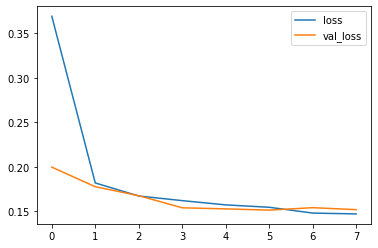

In [49]:
# plot of loss and val_loss
metrics[['loss','val_loss']].plot()

<AxesSubplot:>

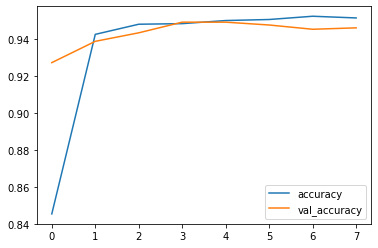

In [50]:
# plot of accuracy and validation accuracy
metrics[['accuracy','val_accuracy']].plot()

In [51]:
# making predictions on the test set
pred_prob=model.predict(test_img_gen)

In [55]:
pred_prob

array([[4.6086545e-05],
       [1.9354471e-05],
       [4.6610392e-05],
       ...,
       [9.8555982e-01],
       [9.9271506e-01],
       [9.8919964e-01]], dtype=float32)

In [56]:
# since a value greater than 0.5 would mean 1 and less than 0.5 would mean 0
predictions=pred_prob > 0.5
predictions

array([[False],
       [False],
       [False],
       ...,
       [ True],
       [ True],
       [ True]])

In [57]:
# the classes of the test data
test_img_gen.classes

array([0, 0, 0, ..., 1, 1, 1])

In [58]:
print(classification_report(test_img_gen.classes,predictions))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1300
           1       0.94      0.97      0.95      1300

    accuracy                           0.95      2600
   macro avg       0.95      0.95      0.95      2600
weighted avg       0.95      0.95      0.95      2600



In [59]:
print(confusion_matrix(test_img_gen.classes,predictions))

[[1217   83]
 [  45 1255]]


**Checking our prediction for a particular image**

In [61]:
# loading the image of the infected cell
my_image=image.load_img(para_cell,target_size=img_shape)

In [62]:
# converting it into an array
my_image=image.img_to_array(my_image)

In [63]:
my_image.shape

(130, 130, 3)

In [64]:
# expanding dimensions so that it is of the form (batch_size, height, width, number of color channels)
my_image=np.expand_dims(my_image,axis=0)

In [65]:
my_image.shape

(1, 130, 130, 3)

In [66]:
model.predict(my_image)>0.5

array([[False]])

In [67]:
train_img_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

**Our model predicted correctly on the sample image of an infected cell.**